# Setting

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import ete3
import hdbscan
import pandas as pd
from scipy.cluster import hierarchy
import umap

## modules

In [5]:
def reduce_dimensions(props, n_neighbors):
    # large n_neighbors, low min_dist
    embedder = umap.UMAP(
        n_neighbors=n_neighbors, min_dist=0.0, metric='correlation',
        random_state=3049821
    )
    embedding = embedder.fit_transform(props.values.T)
    embedding = pd.DataFrame(
        embedding, columns=['umap1', 'umap2'],
        index=pd.Index(props.columns, name='sample_id')
    )
    return embedding


def construct_internal_node_name(node, leaf_names):
    leaf_names = node.pre_order(lambda x: leaf_names[x.id])
    leaf_names.sort()
    return ''.join(leaf_names)


def _tree_to_newick(node, parent_dist, leaf_names, is_root=False):
    if node.is_leaf():
        return '{}:{:.10g}'.format(leaf_names[node.id], parent_dist - node.dist)

    left_newick = _tree_to_newick(node.get_left(), node.dist, leaf_names)
    right_newick = _tree_to_newick(node.get_right(), node.dist, leaf_names)

    node_name = construct_internal_node_name(node, leaf_names)

    if is_root:
        newick = '({},{}){};'.format(left_newick, right_newick, node_name)
    else:
        newick = '({},{}){}:{:.10g}'.format(
            left_newick, right_newick, node_name, parent_dist - node.dist
        )
    return newick


def tree_to_newick(tree, leaf_names):
    return _tree_to_newick(tree, tree.dist, leaf_names, True)


def cluster_sample_embeddings(embedding, min_samples, min_cluster_size,
        cluster_selection_epsilon):

    # low min_samples, quite large min_cluster_size
    clusterer = hdbscan.HDBSCAN(
        min_samples=min_samples, min_cluster_size=min_cluster_size,
        approx_min_span_tree=False, gen_min_span_tree=True,
        allow_single_cluster=False, cluster_selection_method='leaf',
        cluster_selection_epsilon=cluster_selection_epsilon
    )
    cluster_labels = clusterer.fit_predict(embedding)

    cluster_labels = pd.DataFrame(
        cluster_labels + 1, columns=['cluster_id'], index=embedding.index
    )

    print(cluster_labels['cluster_id'].sort_values().unique())

    tree = hierarchy.to_tree(clusterer.single_linkage_tree_.to_numpy())
    nw = tree_to_newick(tree, embedding.index)
    tree = ete3.Tree(nw, format=1)

    return cluster_labels, tree, clusterer


def plot_embeddings(embeddings, clusters, clusterer, pdf_path):
    plot_data = embeddings.reset_index().merge(clusters.reset_index())

    clusters = plot_data['cluster_id'].unique()
    clusters.sort()

    
    if clusters.max() > 15:
        colour_palette = sns.color_palette('husl', clusters.max())
    else:
        colour_palette = sns.color_palette([
            '#4292c6', # blue
            '#fd8d3c', # orange
            '#41ab5d', # green
            '#e31a1c', # red
            '#dcbeff', # lavendar
            '#88419d', # purple
            '#d94801', # dark orange
            '#b35806', # brown
            '#a6761d', # drab brown
            '#969696', # gray
            '#252525', # black
            '#006400', # dark green
            '#191970', # midnight blue
            '#ffb6c1', # light pink
            '#c71585' # medium violet red
        ])

    colour_palette = {
        x: (colour_palette[x - 1] if x > 0 else (0.5, 0.5, 0.5))
        for x in clusters
    }

    f, ax = plt.subplots(figsize=(6.5, 6.5))
    sns.despine(f, left=True, bottom=True)
    sns.scatterplot(
        x='umap1', y='umap2', hue='cluster_id', linewidth=0,
        data=plot_data, ax=ax, palette=colour_palette
    )

    plt.savefig(pdf_path)


In [6]:
def plot_heatmap(plot_data, figsize=(20, 10), out_path=None):
    assert plot_data.index[-1] == 'cluster_id', plot_data.index
    fig, (ax1, axh) = plt.subplots(2, 1, figsize=figsize, 
                                   gridspec_kw={'height_ratios':[1, 30], 'hspace':0.01})
    sns.heatmap(plot_data.iloc[:-1, :], cmap="vlag", ax=axh, cbar=False, vmin=-1, vmax=1, center=0)
    ax1_hm = sns.heatmap(plot_data.loc[['cluster_id']], ax=ax1, cbar=False, cmap='tab20')
    ax1.set_xticks([])
    ax1_hm.set_yticklabels(['cluster'], rotation=0); 
    # fig.tight_layout()
    if out_path:
        fig.savefig(out_path, bbox_inches='tight')

# Data

In [98]:
sigs_path = '/juno/work/shah/users/chois7/tickets/breast-mmctm/train/results/analysis/signatures/mmctm_props_standardized.tsv'
sigs = pd.read_table(sigs_path, index_col=0).T
clust_path = '/juno/work/shah/users/chois7/tickets/breast-mmctm/train/results/analysis/signatures/mmctm_props_hdbscan_clusters.tsv'
clust = pd.read_table(clust_path, index_col=0)

In [99]:
sigs = sigs.join(clust).sort_values(['cluster_id']).T

## complex svs

In [14]:
orig_path = '/work/shah/users/leej39/bc_evolution/mmctm/svtm.simplified.120524.v1.tsv'
orig = pd.read_table(orig_path, index_col=0)

In [16]:
orig.index.name = 'term'

In [18]:
dst = orig.T

In [23]:
dst_path = '/juno/work/shah/users/chois7/tickets/breast-mmctm/train/results/analysis/counts/sv_counts.tsv'
dst.to_csv(dst_path, sep='\t')

In [21]:
samples = list(dst.columns)
samples_path = '/juno/work/shah/users/chois7/tickets/mmctm-pipeline-gdan/resources/samples.txt'
with open(samples_path, 'w') as out:
    for sample in samples:
        out.write(sample + '\n')

## complex sv plot

In [9]:
import matplotlib

In [90]:
sv_path = '/juno/work/shah/users/chois7/tickets/breast-mmctm/train/results/analysis/counts/sv_counts.tsv'
sv = pd.read_table(sv_path, index_col=0)

In [117]:
sv.T.describe()

term,simple_del_1,simple_del_2,simple_del_3,simple_del_4,simple_del_5,simple_dup_1,simple_dup_2,simple_dup_3,simple_dup_4,simple_dup_5,...,med_multi_not,med_multi_amp,large_uni_not,large_uni_amp,large_oligo_not,large_oligo_amp,large_multi_not,large_multi_amp,line1_ins,incomplete
count,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,...,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000
mean,45.525641,6.479487,3.473077,1.001282,0.828205,18.001282,11.693590,8.928205,2.187179,0.517949,...,0.023077,0.030769,0.005128,0.021795,0.008974,0.153846,0.002564,0.046154,2.532051,7.837179
std,80.442155,11.107519,6.396248,1.468977,1.276317,57.093588,30.054716,22.065894,8.001177,1.026447,...,0.150244,0.193812,0.071473,0.146107,0.094368,0.398229,0.050604,0.209953,10.081962,9.293829
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,11.000000,2.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000
75%,42.500000,8.000000,4.000000,1.000000,1.000000,5.000000,5.000000,8.000000,2.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,11.000000
max,569.000000,115.000000,105.000000,12.000000,9.000000,847.000000,257.000000,235.000000,181.000000,6.000000,...,1.000000,2.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,227.000000,102.000000


In [132]:
pdata = sv.iloc[10:-2]

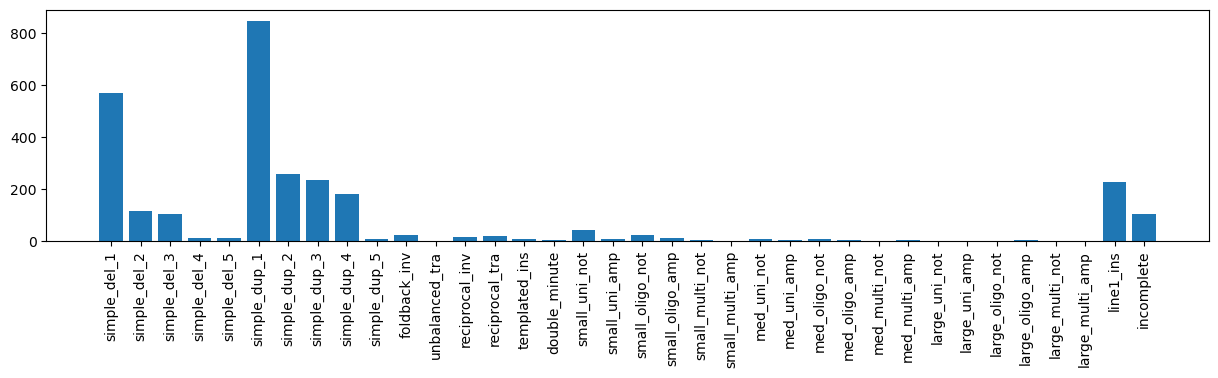

In [127]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.bar(x=range(pdata.index.shape[0]), height=pdata.T.describe().loc['mean'])
ax.set_xticks(range(pdata.index.shape[0]));
ax.set_xticklabels(pdata.index);
# ax.set_yscale('log');
plt.xticks(rotation=90);

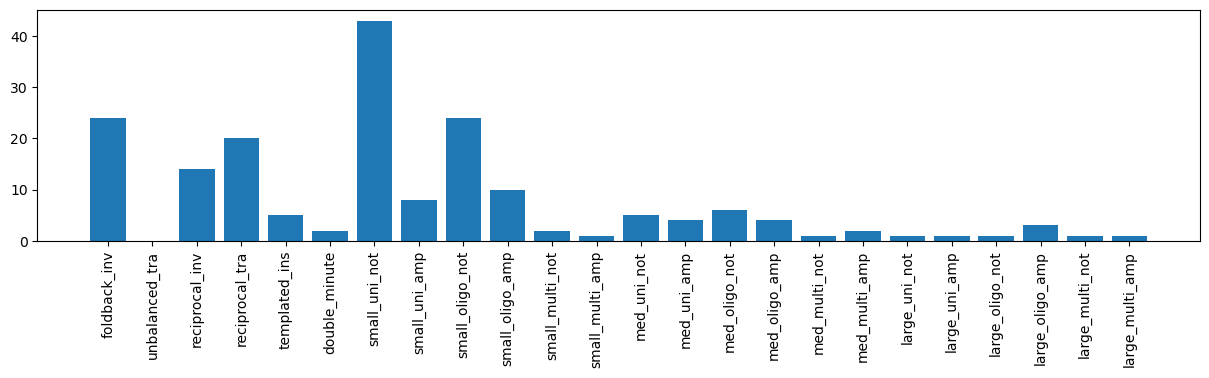

In [134]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.bar(x=range(pdata.index.shape[0]), height=pdata.T.describe().loc['max'])
ax.set_xticks(range(pdata.index.shape[0]));
ax.set_xticklabels(pdata.index);
# ax.set_yscale('log');
plt.xticks(rotation=90);

In [10]:
def get_var_sig(var_sig_path, vartype="SNV", debug=False):
    var = pd.read_table(var_sig_path, index_col=3)
    var = var[var.modality == vartype] # SNV, SV, INDEL
    var = var.set_index(var.index.str.replace("->", ">"))
    if debug: print(var.shape)
    if debug: print(var.head())
    return var

In [84]:
def plot_sv_spectra(sv, title, ax):
    sv_colors = {
        "simple_del_1": "#B4E3FF",
        "simple_del_2": "#88B3E9",
        "simple_del_3": "#5B83D3",
        "simple_del_4": "#2F53BD",
        "simple_del_5": "#0223A7",
        "simple_dup_1": "#FFB5B5",
        "simple_dup_2": "#E98888",
        "simple_dup_3": "#D35C5C",
        "simple_dup_4": "#BC2F2F",
        "simple_dup_5": "#A60202",
        "foldback_inv": "tab:orange",
        "unbalanced_tra": "#D9ABFF",
        "reciprocal_inv": "#007527",
        "reciprocal_tra": "#7E11C7",
        "templated_ins": "#ABFFB5",
        "double_minute": "tab:brown",
        "small_uni_not": "#FFDFA7",
        "small_uni_amp": "#EEBF90",
        "small_oligo_not": "#DD9F79",
        "small_oligo_amp": "#CB8063",
        "small_multi_not": "#BA604C",
        "small_multi_amp": "#A94035",
        "med_uni_not": "#6CC257",
        "med_uni_amp": "#58AB51",
        "med_oligo_not": "#44944B",
        "med_oligo_amp": "#317C44",
        "med_multi_not": "#1D653E",
        "med_multi_amp": "#094E38",
        "large_uni_not": "#7454DD",
        "large_uni_amp": "#6344C0",
        "large_oligo_not": "#5334A2",
        "large_oligo_amp": "#422585",
        "large_multi_not": "#321567",
        "large_multi_amp": "#21054A",
        "line1_ins": "tab:green",
        "incomplete": "tab:grey",
    }
    font = matplotlib.font_manager.FontProperties()
    font.set_family('monospace')

    terms = sv.index
    for svtype, row in sv.iterrows():
        value = row['value']
        prob = row['probability']
        ax.bar(x=[value], height=[prob], color=sv_colors[svtype], label=svtype)

    ax.set_xticks(sv['value'])
    ax.set_xticklabels(terms, fontproperties=font, rotation=90)
    for xtl in ax.xaxis.get_ticklabels():
        if '_amp' in xtl.get_text():
            xtl.set_color('red')

    ax.set_xlim((0.5, sv.shape[0]+1))
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=7, ncol=3)

    sns.despine(trim=True, ax=ax)
    return df

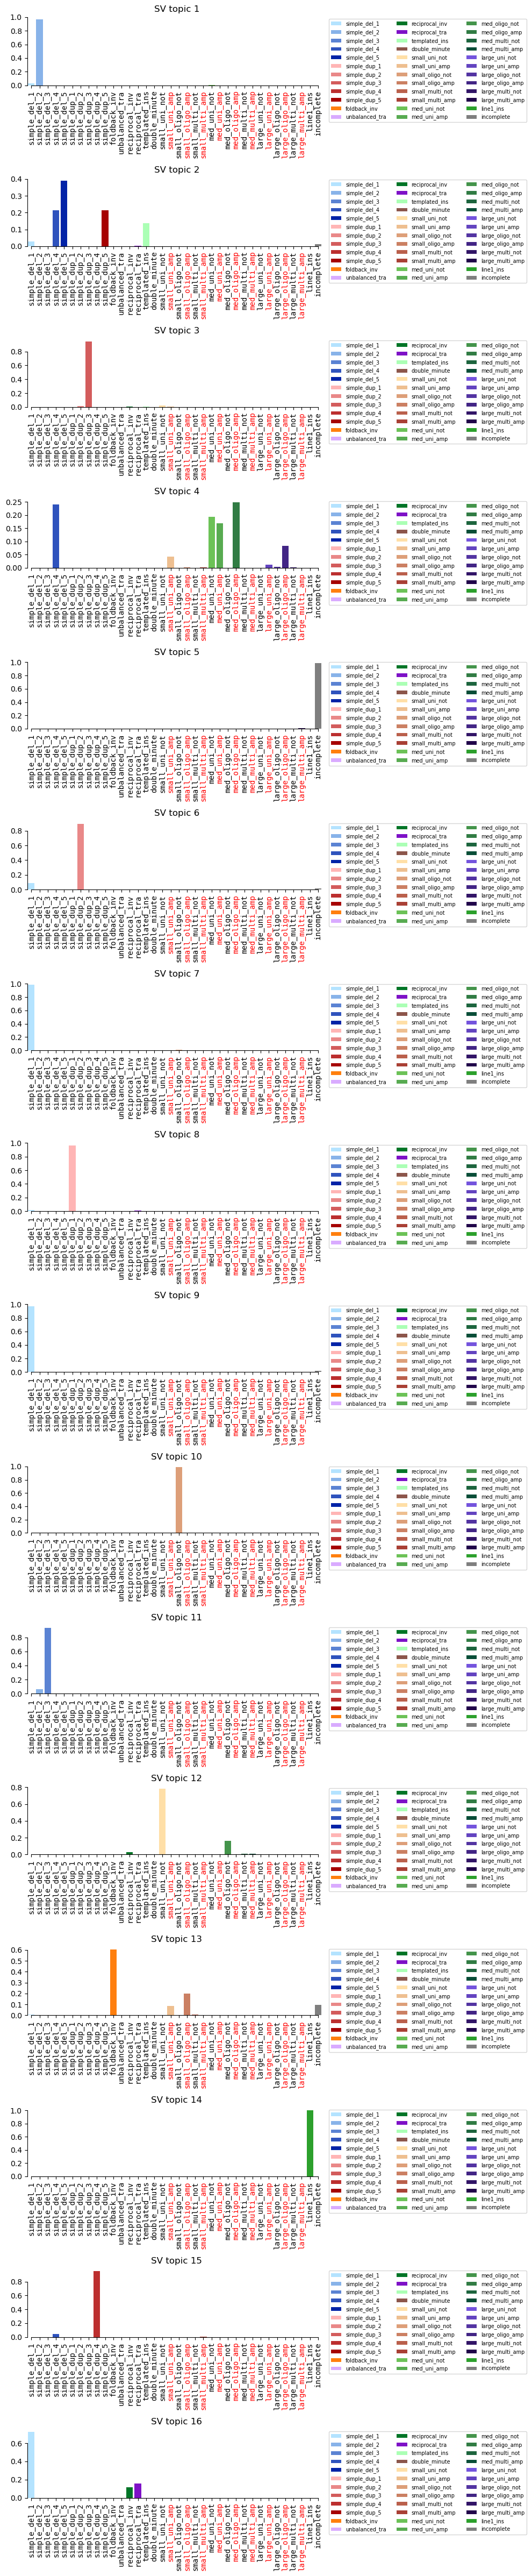

In [135]:
sigs_path = '/juno/work/shah/users/chois7/tickets/breast-mmctm/train/results/analysis/model/SNV9_SV16_INDEL8/model_sigs.tsv'
sv = get_var_sig(sigs_path, vartype='SV')
n_sv_topics = sv.topic.unique().shape[0]
fig, axes = plt.subplots(n_sv_topics, 1, figsize=(10, 3 * n_sv_topics))
for ix, topic in enumerate(sv.topic.unique()):
    ax = axes[ix]
    topic_sv = sv[sv['topic']==topic].copy()
    title = f"SV topic {topic}"
    ax.set_title(title)
    df = plot_sv_spectra(topic_sv, title, ax)
    # break
plt.tight_layout()

## match samples to 780

In [27]:
snv_path = '/juno/work/shah/users/chois7/tickets/breast-mmctm/train/results/analysis/counts/782_samples/snv_counts.tsv'
snv_out_path = '/juno/work/shah/users/chois7/tickets/breast-mmctm/train/results/analysis/counts/snv_counts.tsv'
snv = pd.read_table(snv_path, index_col=0)
snv = snv[samples]
snv.to_csv(snv_out_path, sep='\t')

In [28]:
indel_path = '/juno/work/shah/users/chois7/tickets/breast-mmctm/train/results/analysis/counts/782_samples/indel_counts.tsv'
indel_out_path = '/juno/work/shah/users/chois7/tickets/breast-mmctm/train/results/analysis/counts/indel_counts.tsv'
indel = pd.read_table(indel_path, index_col=0)
indel = indel[samples]
indel.to_csv(indel_out_path, sep='\t')

# Proc

In [186]:
sigs

,PD13760,PD24205,BR090,BR085,PD4116,PD4604,BR078,BR077,PD4844,PD4872,...,PD24216,IBC232,PD18251,BR084,PD6404,BR023,PD24308,PD4836,BR011,PD6729
SBS1,-0.561136,-1.008294,-0.702228,-1.007565,-1.209238,-0.939162,-1.230944,-0.893277,-1.062650,-1.142867,...,-1.110257,-0.186790,-0.703345,-0.980328,-0.659873,-0.819184,-0.605581,-0.102802,0.216668,0.472971
SBS2,-0.472230,-0.668733,-0.794907,-0.526017,-0.519081,-0.564482,-0.397459,-0.722646,-0.647385,0.050118,...,1.746343,-0.731058,-0.502654,-0.675591,-0.434273,-0.687968,-0.705575,-0.589723,-0.613608,-0.699003
SBS3,0.896365,1.451248,1.424064,1.208112,1.598935,1.551015,1.031013,1.474848,1.823826,0.888913,...,-0.677575,0.829611,0.629280,0.832628,1.198531,1.497830,0.546236,0.722845,0.677597,1.200412
SBS7b,-0.716600,-0.355842,-0.912911,-0.304673,-0.763997,0.016119,-0.497871,-0.625458,-1.020913,-0.681227,...,-1.261489,-0.636640,0.409939,2.241646,-0.493445,-0.196877,0.320518,0.212488,0.160705,-0.312114
SBS12,-0.060027,-0.191578,0.354585,-0.110208,0.322010,0.340667,-0.597194,0.390311,0.660288,-0.342046,...,0.808416,0.476820,1.465538,-0.335169,0.381500,0.451540,1.565473,0.355806,-0.071171,0.194793
SBS13,0.266293,-0.491481,-0.684243,-0.224858,-0.051802,-0.325941,0.043388,-0.020826,-0.157350,0.415310,...,1.412802,-0.259419,-0.449081,-0.425136,-0.128520,-0.525327,-0.270068,-0.210816,-0.512078,-0.466347
SBS17b,0.003283,0.156803,-0.031224,0.023063,0.147438,0.199071,0.059897,0.566721,0.265374,-0.265383,...,-0.474919,0.337543,0.512196,-0.122091,1.124518,0.249113,0.298056,-0.124715,0.347652,0.134577
SBS18,0.577959,0.922853,1.121771,0.580067,0.210074,-0.297591,1.134413,-0.511748,-0.074449,0.181008,...,-0.752148,0.505241,-0.461513,-0.387456,-1.135262,-0.296633,-0.689517,-0.476853,-0.238399,-0.537189
SBS44,-0.398762,0.641530,0.910795,0.675601,0.194047,0.118430,0.592537,0.479513,0.143265,0.509329,...,-1.246537,-0.125112,-0.135276,0.563416,0.391862,0.918436,0.420203,0.447504,0.465332,-0.203491
Del-1kb,0.271263,2.831960,2.889788,3.277501,1.408111,2.324449,2.026758,2.094951,2.567334,1.285217,...,0.701229,-0.450998,-0.460576,-0.144835,-0.021902,0.152483,-0.497222,0.772870,-0.239947,0.029101


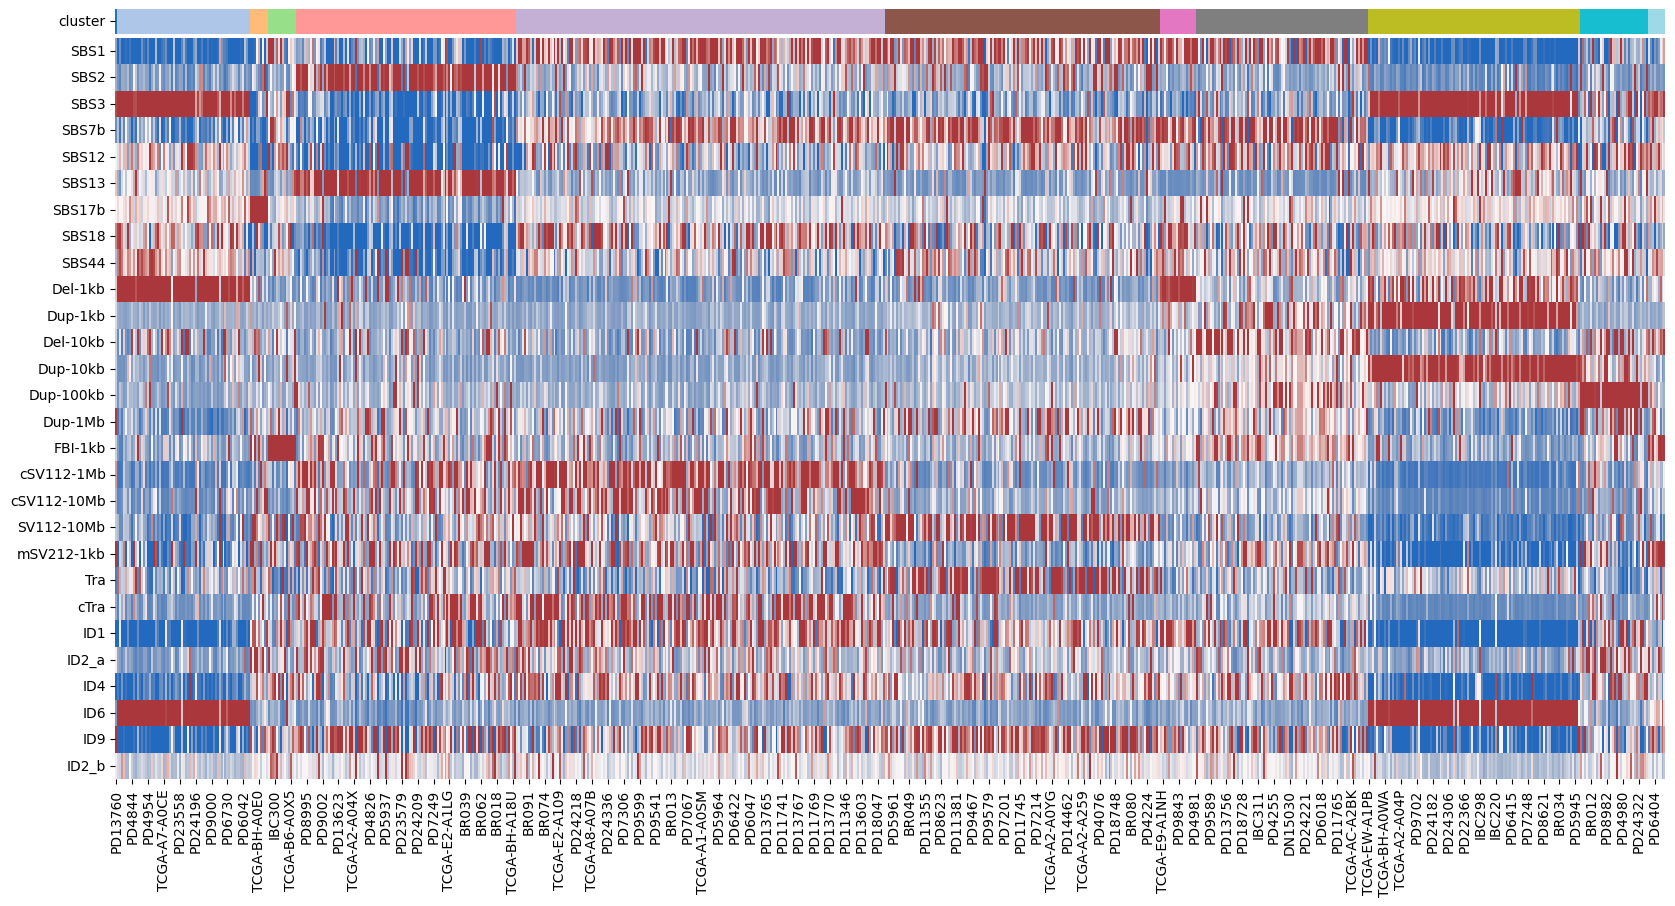

In [183]:
plot_data = sigs.copy()
png_path = f'/juno/work/shah/users/chois7/tickets/breast-mmctm/fit/results/plots/SNV9_SV13_INDEL6/cluster.all.png'
plot_heatmap(plot_data, out_path=png_path)

# Clust

/juno/work/shah/users/chois7/envs/p37/lib/python3.7/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


[0 1 2 3 4 5 6]


/juno/work/shah/users/chois7/envs/p37/lib/python3.7/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


[0]


/juno/work/shah/users/chois7/envs/p37/lib/python3.7/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


[0]


/juno/work/shah/users/chois7/envs/p37/lib/python3.7/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


[0 1 2 3 4 5 6 7 8 9]


/juno/work/shah/users/chois7/envs/p37/lib/python3.7/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


[0 1 2 3 4 5 6 7 8 9]


/juno/work/shah/users/chois7/envs/p37/lib/python3.7/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


[ 0  1  2  3  4  5  6  7  8  9 10 11]


/juno/work/shah/users/chois7/envs/p37/lib/python3.7/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


[0]


/juno/work/shah/users/chois7/envs/p37/lib/python3.7/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


[0 1 2 3 4 5 6 7 8]


/juno/work/shah/users/chois7/envs/p37/lib/python3.7/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


[0 1 2 3 4 5 6 7 8]


/juno/work/shah/users/chois7/envs/p37/lib/python3.7/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


[1 2]


/juno/work/shah/users/chois7/envs/p37/lib/python3.7/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


[0]


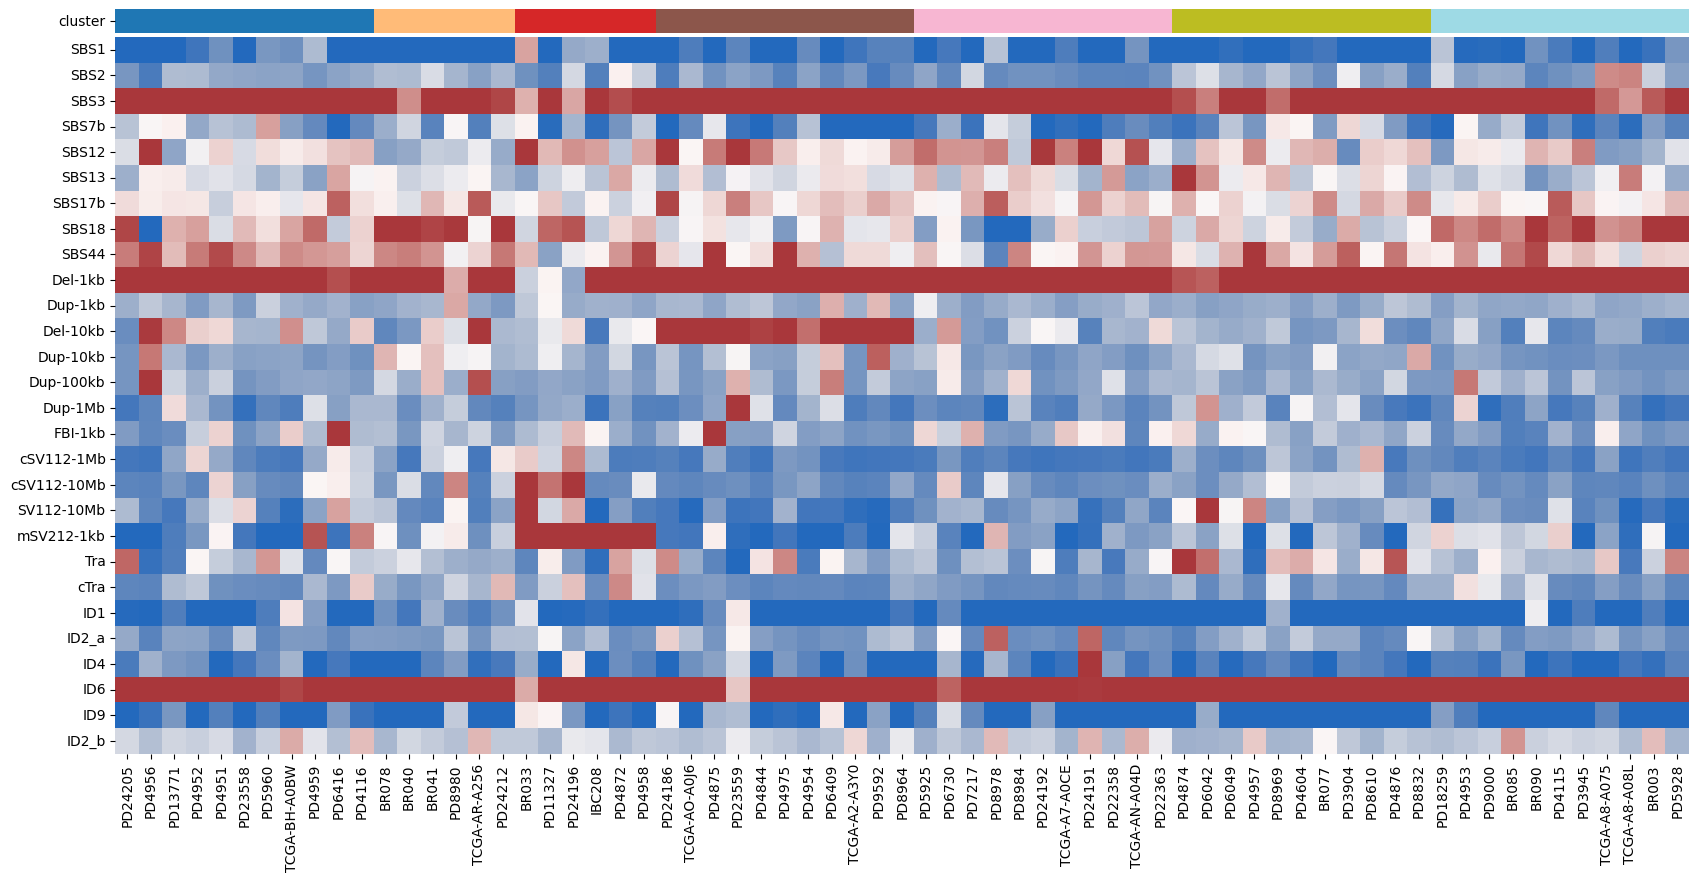

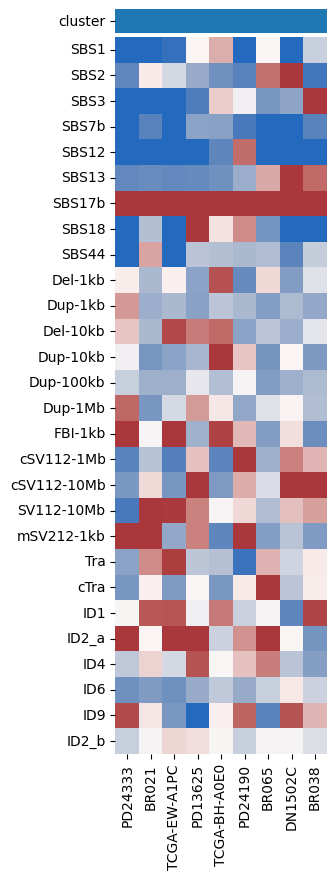

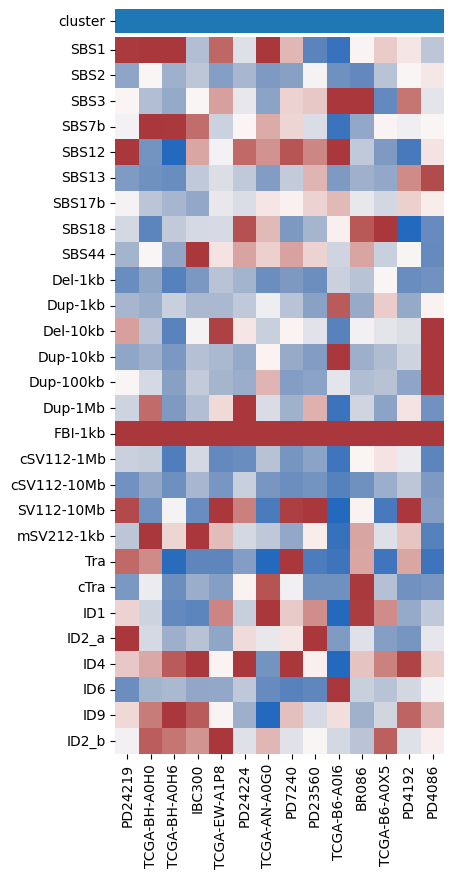

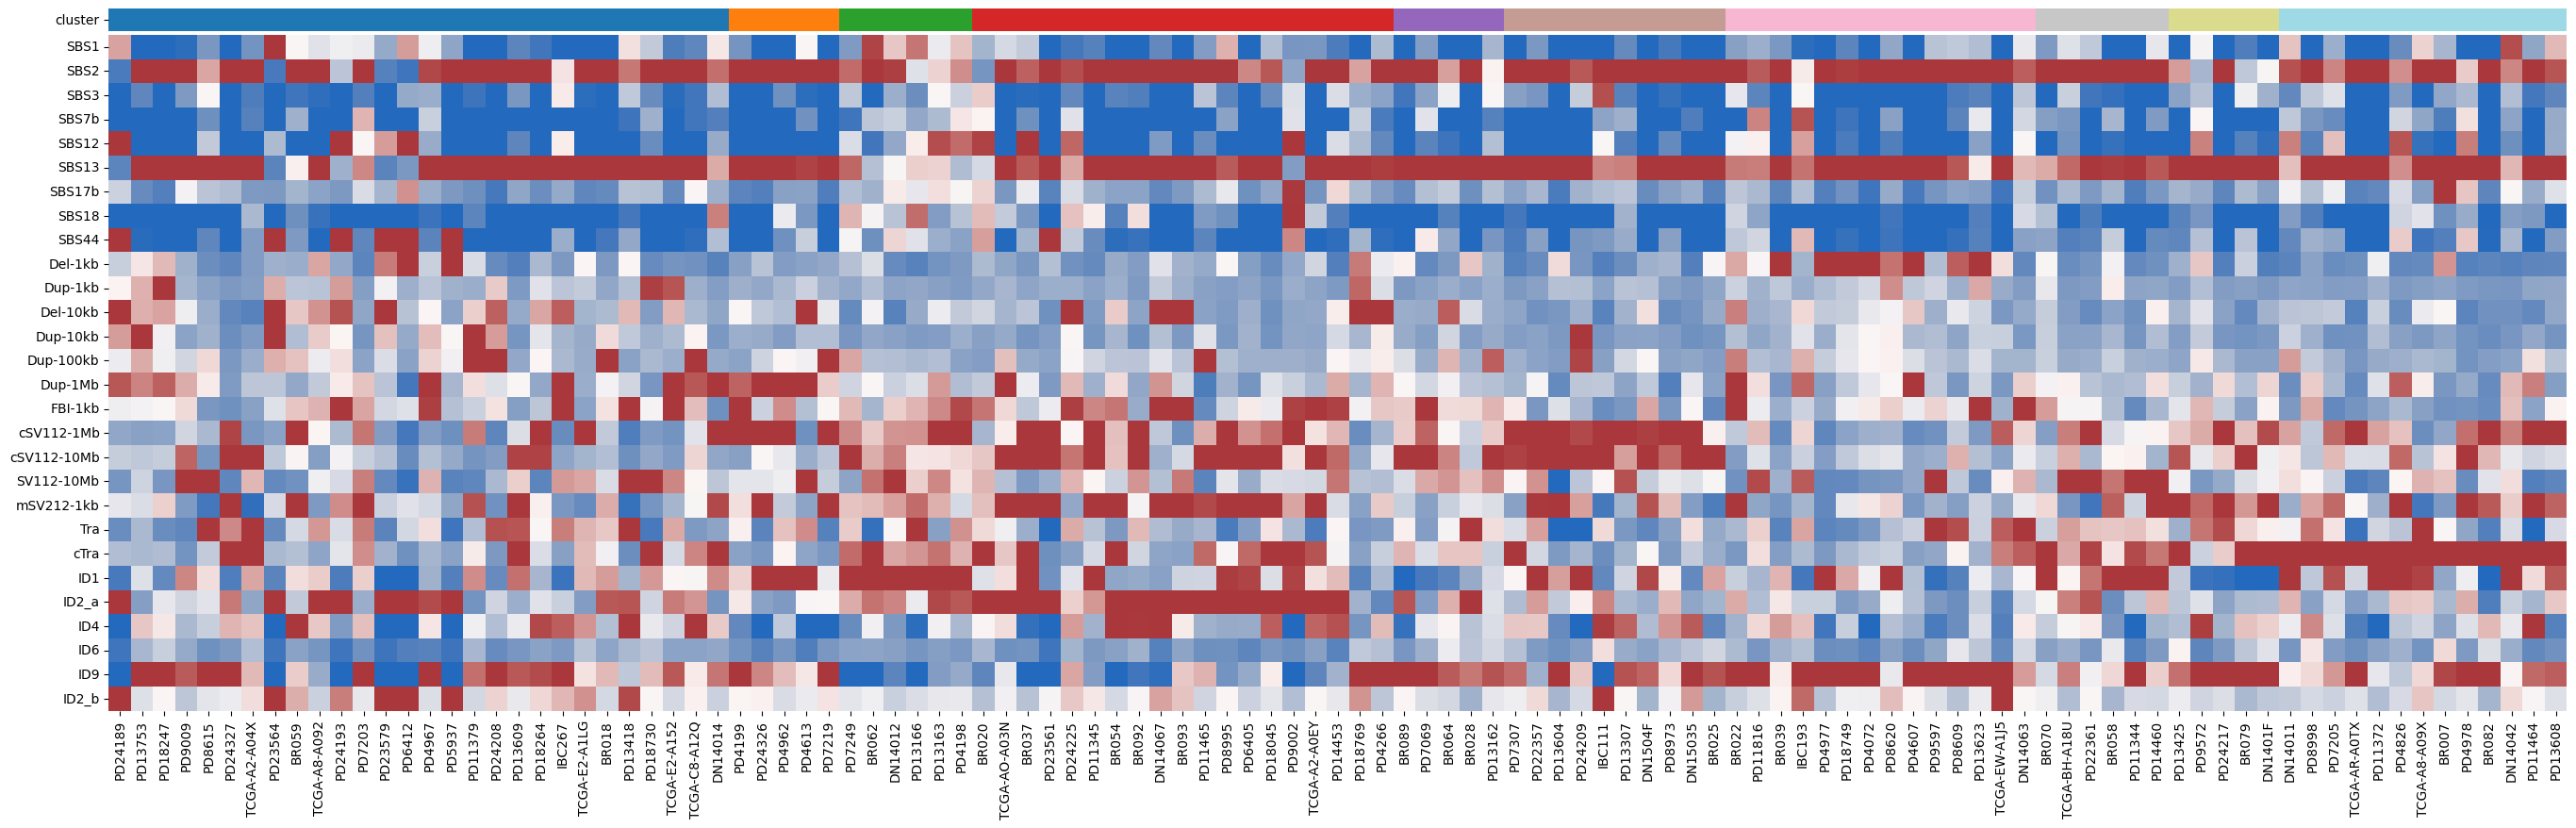

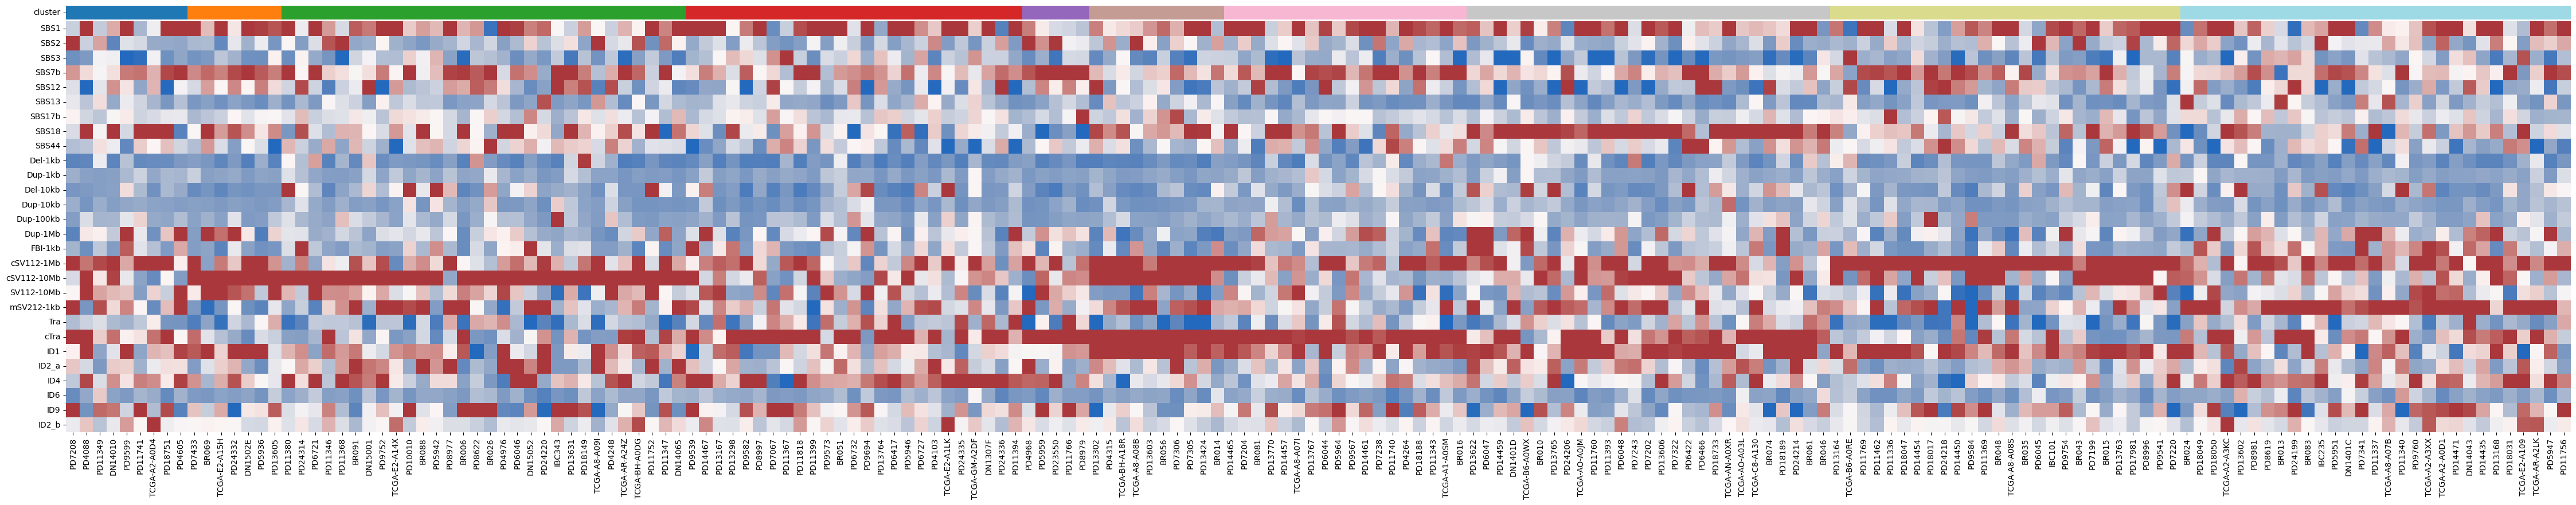

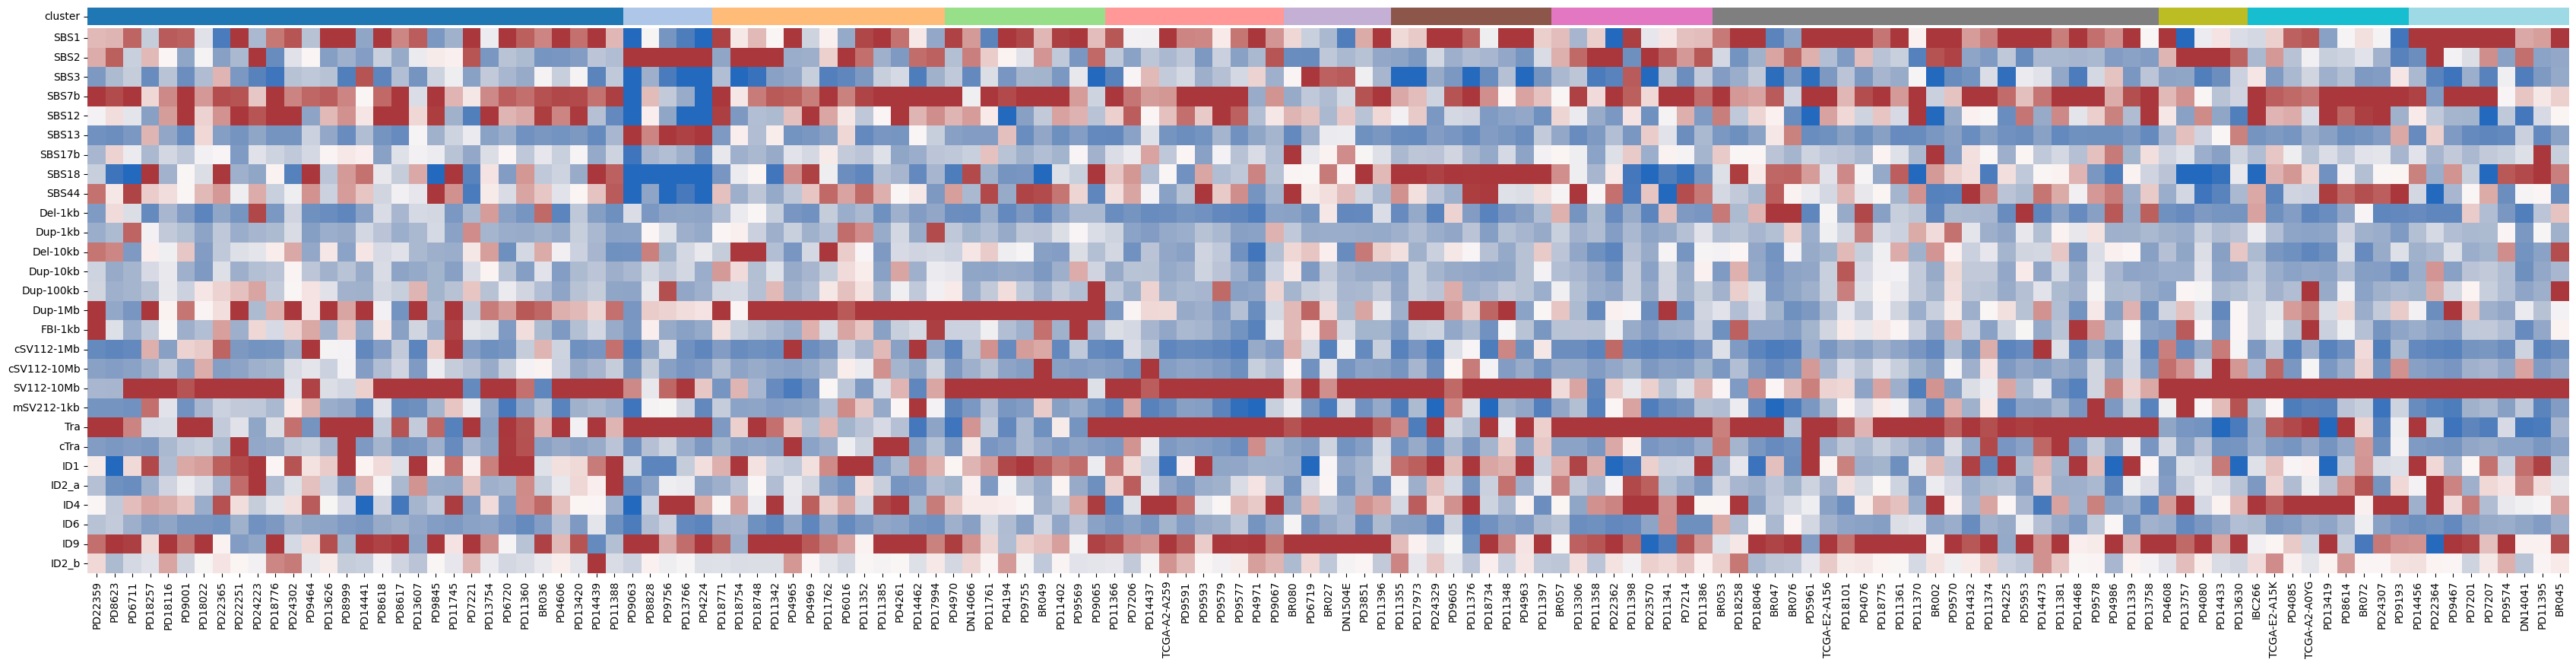

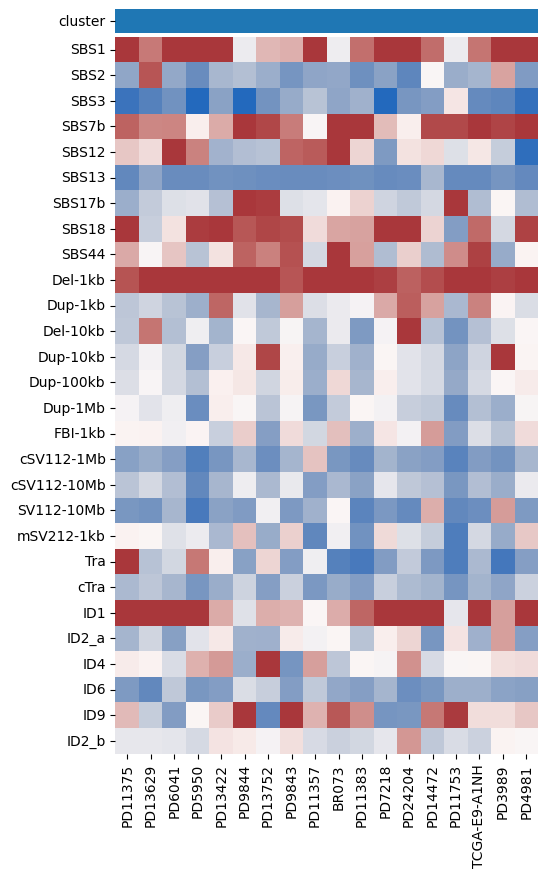

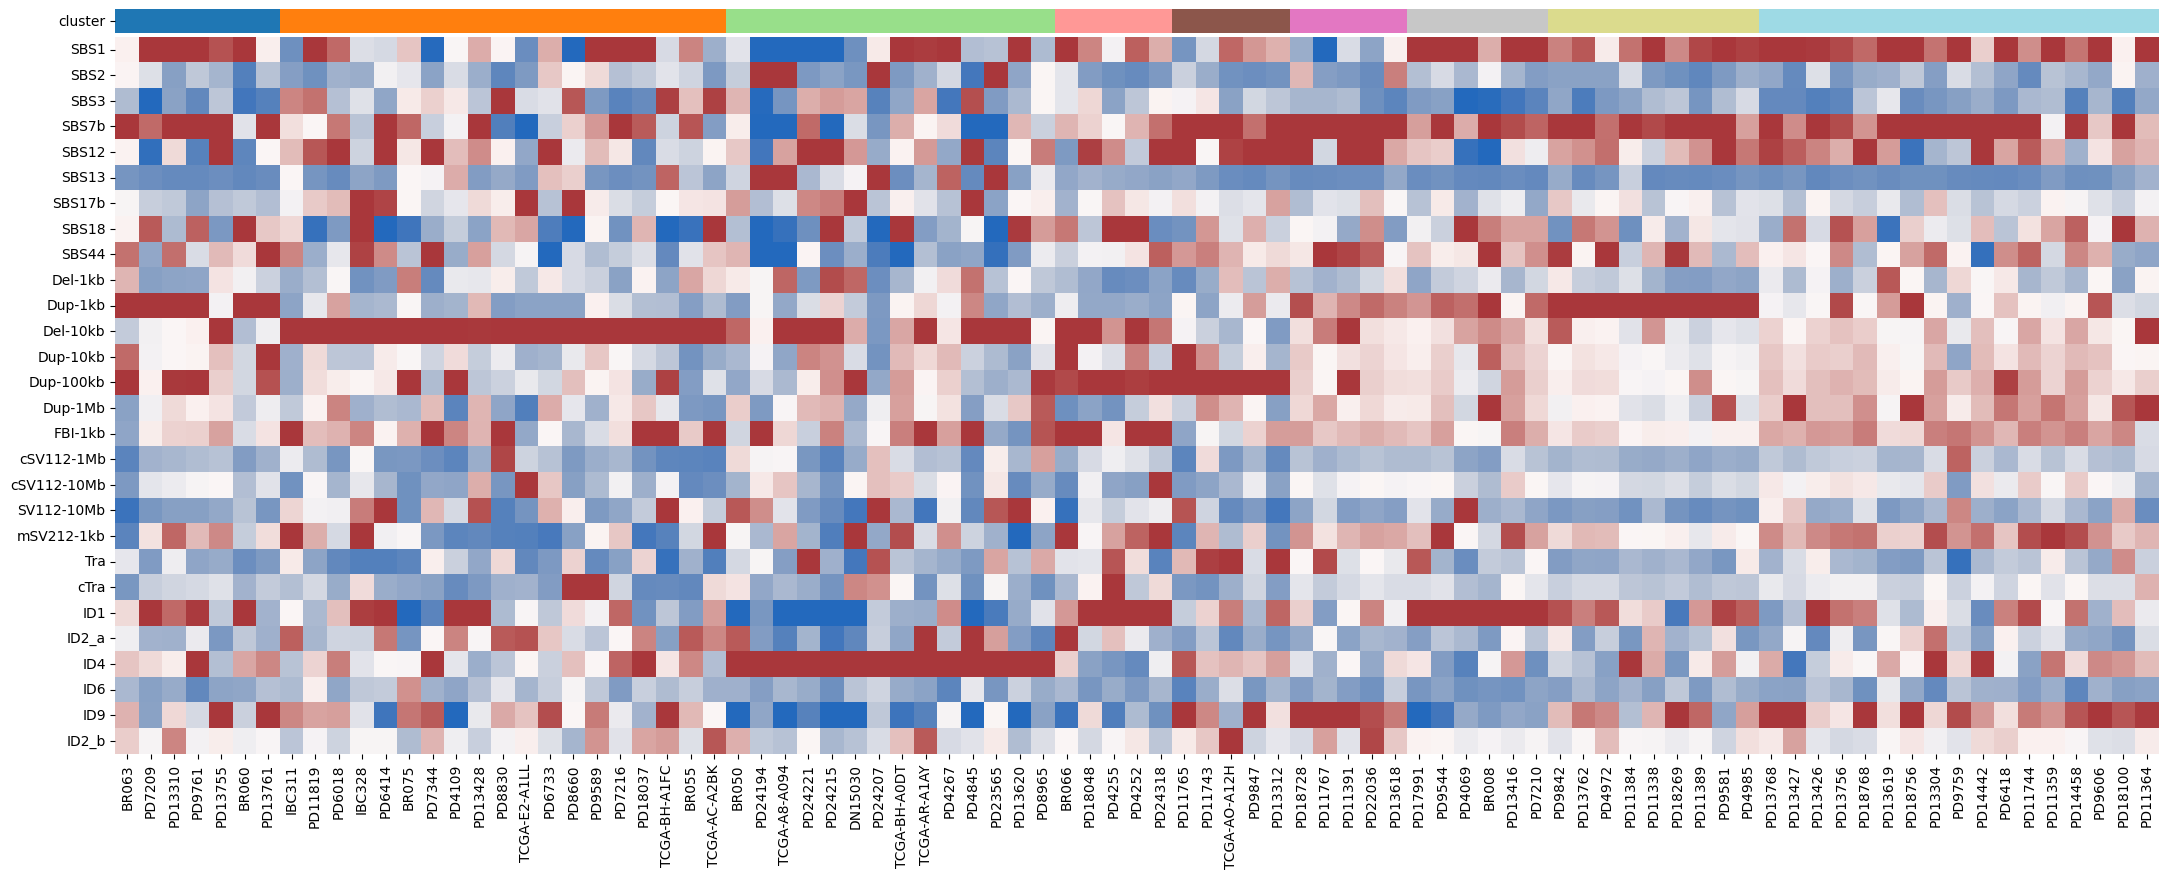

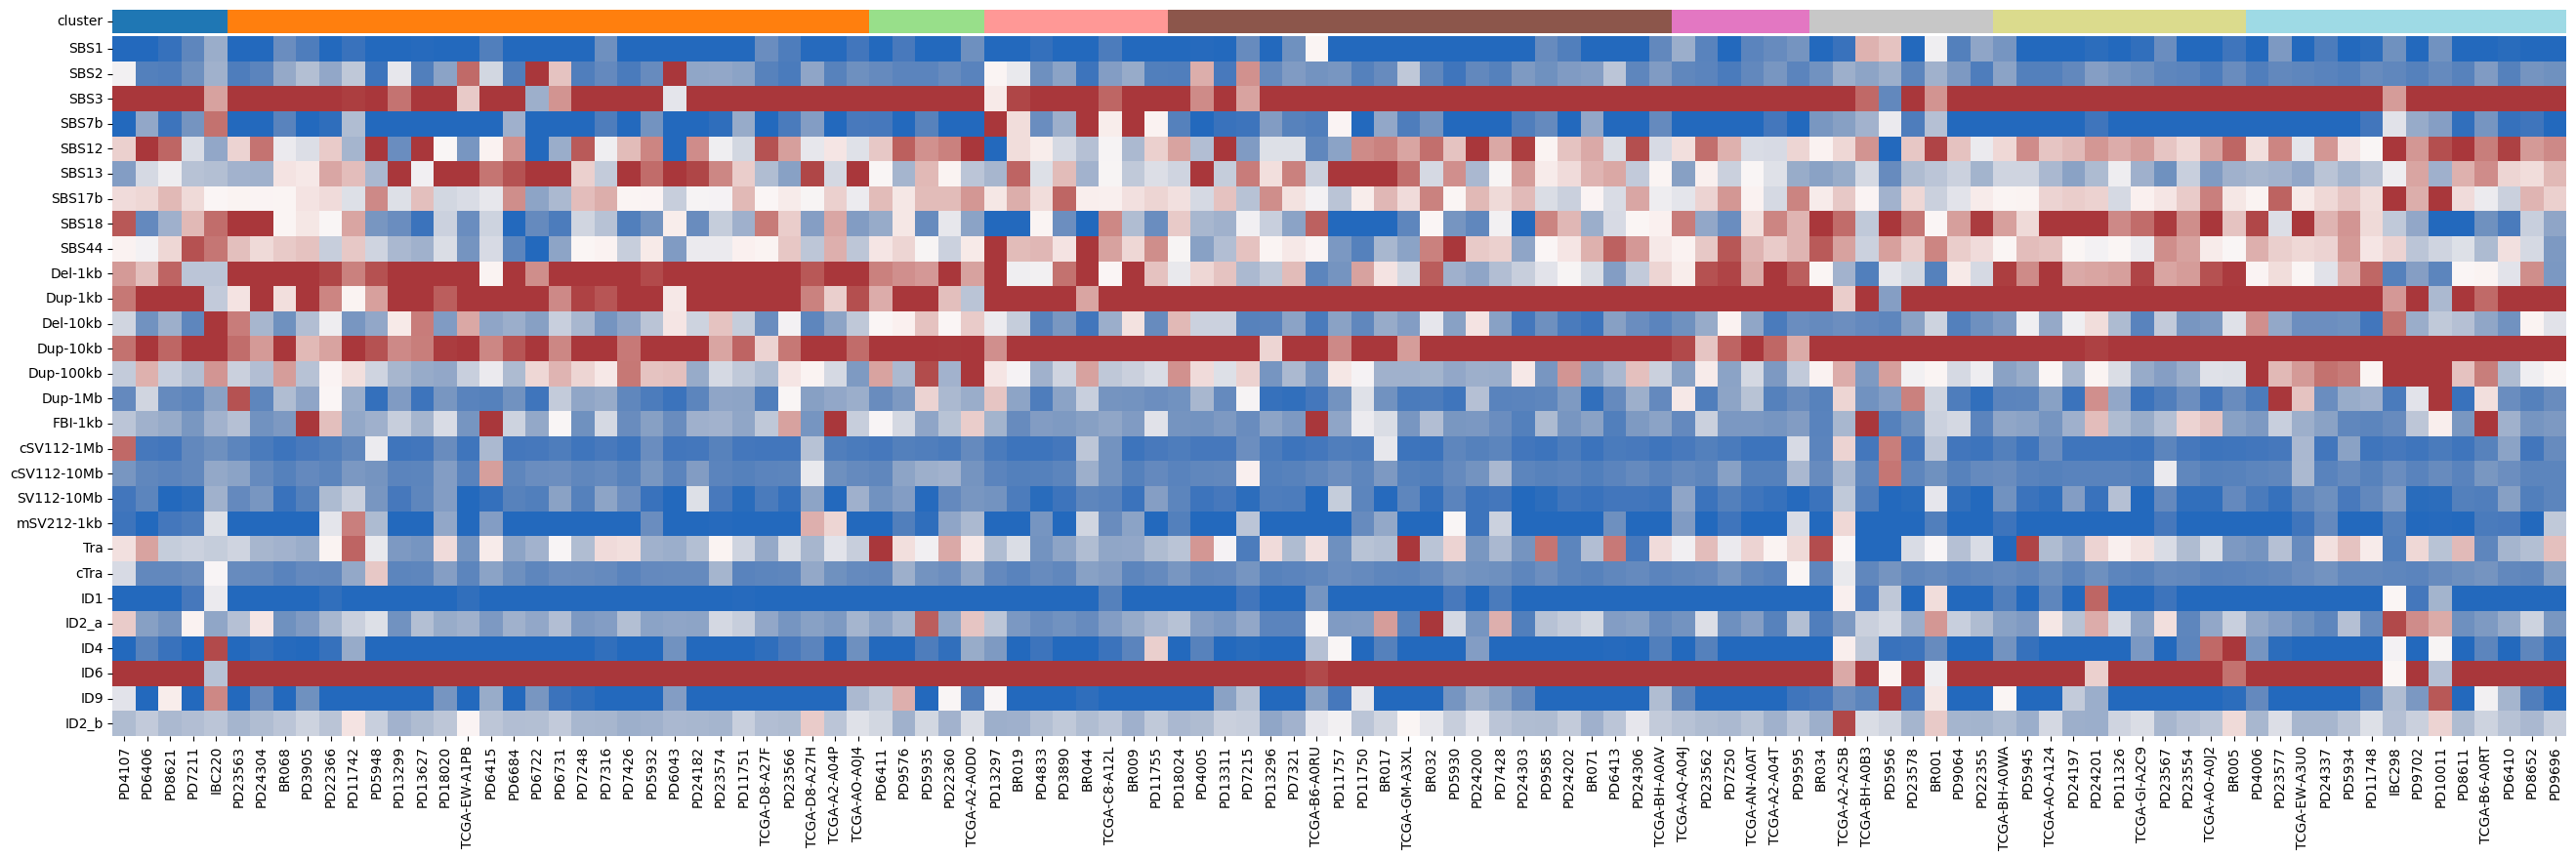

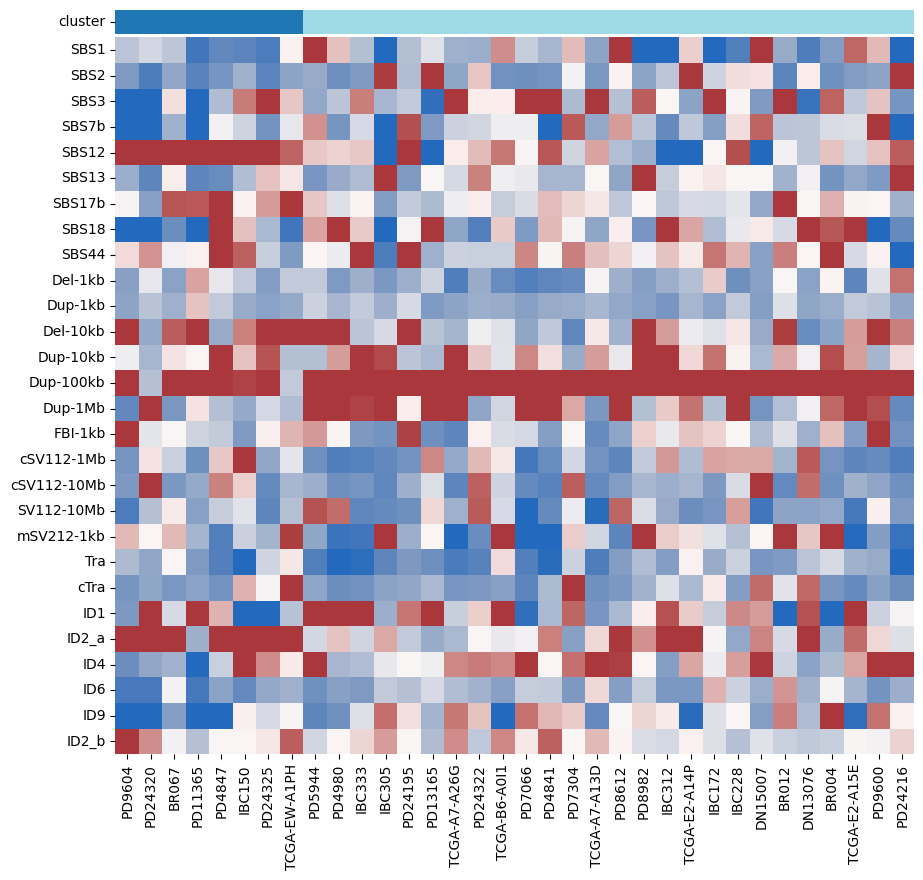

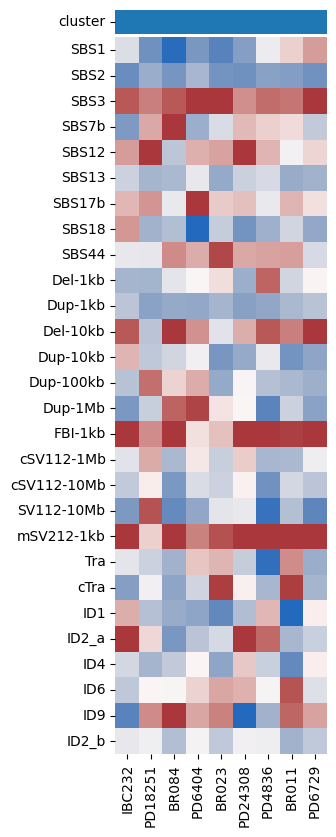

In [184]:
for cluster_id in range(1, 11+1):
    ssigs = sigs.loc[:, sigs.loc['cluster_id'] == cluster_id]
    ssigs.shape
    props = ssigs.iloc[:-1, :]

    n_neighbors = 4
    min_samples = 4
    cluster_selection_epsilon = 0.5

    embeddings = reduce_dimensions(props, n_neighbors)
    clusters, tree, clusterer = cluster_sample_embeddings(
        embeddings, min_samples, 5, cluster_selection_epsilon
    ) 
    props = props.T.join(clusters).sort_values(['cluster_id']).T
    png_path = f'/juno/work/shah/users/chois7/tickets/breast-mmctm/fit/results/plots/SNV9_SV13_INDEL6/cluster.{cluster_id}.png'
    plot_data = props.copy()
    nrow, ncol = props.shape
    figsize = (ncol / 3.3, nrow / 3)
    plot_heatmap(plot_data, figsize=figsize, out_path=png_path)